# Neural Network for decision making in vaccination
Ezequiel Alvarez & Franco Marsico
franco.lmarsico@gmail.com sequi@unsam.edu.ar

In [40]:
import pandas as pd
import sys
#!{sys.executable} -m pip install --upgreade numpy
#!{sys.executable} -m pip install --upgreade h5py
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install tf-nightly
!{sys.executable} -m pip install -U "scikit-learn==0.23.1"
!{sys.executable} -m pip matplotlib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from keras.layers import Dense
from matplotlib import pyplot as plt

Requirement already up-to-date: scikit-learn==0.23.1 in /home/franco/snap/jupyter/common/lib/python3.7/site-packages (0.23.1)
ERROR: unknown command "matplotlib"


In [41]:
df = pd.read_csv('SNVS.csv', sep=',', header=0, usecols=["SEXO","EDAD_ACTUAL","ID_PROVINCIA_RESIDENCIA","ID_PROVINCIA_CARGA","CLASIF_RESUMEN","ID_DEPTO_INDEC_RESIDENCIA","ASMA","BAJO_PESO","BRONQUIO_PREVIA","DBT","EMBARAZO","ENF_NEURO_PREVIA","ENF_ONCO_PREVIA","EPOC","HEPATO_CRONICA","HTA","INMUNOS_CONGENITA","INSF_CARDIACA","INSF_RENAL","NAC_PREVIA","OBESIDAD","PREMATURO","SIN_COMORB","TBC","EX_FUMADOR","FUMADOR","DIALISIS_AGUDA","DIALISIS_CRONICA","ID_LOCALIDAD_RESIDENCIA","EMBARAZADA","FALLECIDO"])
df = df[df["CLASIF_RESUMEN"] == "Confirmado"]
del df["CLASIF_RESUMEN"]
df = df.fillna(0)

In [42]:
df = df.replace(["F", "M", "NO", "SI", "NS", "ND","A"," "], [0, 1, 0, 1,0,0,0,0]) #Tanto A como vacio son typos
df = df.astype(float)
display(df[:100])


,SEXO,EDAD_ACTUAL,FALLECIDO,ID_PROVINCIA_RESIDENCIA,ID_PROVINCIA_CARGA,ID_DEPTO_INDEC_RESIDENCIA,ASMA,BAJO_PESO,BRONQUIO_PREVIA,DBT,...,OBESIDAD,PREMATURO,SIN_COMORB,TBC,EX_FUMADOR,FUMADOR,DIALISIS_AGUDA,DIALISIS_CRONICA,ID_LOCALIDAD_RESIDENCIA,EMBARAZADA
2,1.0,45.0,0.0,2.0,2.0,6791.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6791050.0,0.0
4,0.0,49.0,0.0,2.0,2.0,6658.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6058020.0,0.0
8,0.0,24.0,0.0,2.0,2.0,6413.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6413050.0,0.0
14,0.0,39.0,0.0,2.0,1.0,6560.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,24.0,0.0,2.0,2.0,6648.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,1.0,41.0,0.0,2.0,2.0,6357.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6357110.0,0.0
264,1.0,19.0,0.0,2.0,2.0,6028.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,0.0,11.0,0.0,2.0,2.0,6408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,0.0,31.0,0.0,2.0,1.0,6260.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#Standar criterion ROC ref
FPR = df[(df.EDAD_ACTUAL > 60.0) & (df.FALLECIDO == 0)].count() / df[df.FALLECIDO == 0].count()
TPR = df[(df.EDAD_ACTUAL > 60.0) & (df.FALLECIDO == 1)].count() / df[df.FALLECIDO == 1].count()
TPR

SEXO                         0.818113
EDAD_ACTUAL                  0.818113
FALLECIDO                    0.818113
ID_PROVINCIA_RESIDENCIA      0.818113
ID_PROVINCIA_CARGA           0.818113
ID_DEPTO_INDEC_RESIDENCIA    0.818113
ASMA                         0.818113
BAJO_PESO                    0.818113
BRONQUIO_PREVIA              0.818113
DBT                          0.818113
EMBARAZO                     0.818113
ENF_NEURO_PREVIA             0.818113
ENF_ONCO_PREVIA              0.818113
EPOC                         0.818113
HEPATO_CRONICA               0.818113
HTA                          0.818113
INMUNOS_CONGENITA            0.818113
INSF_CARDIACA                0.818113
INSF_RENAL                   0.818113
NAC_PREVIA                   0.818113
OBESIDAD                     0.818113
PREMATURO                    0.818113
SIN_COMORB                   0.818113
TBC                          0.818113
EX_FUMADOR                   0.818113
FUMADOR                      0.818113
DIALISIS_AGU

In [45]:
dataset = df.values
dimensions = dataset.shape[1] -1

X = df.loc[:, df.columns != "FALLECIDO"]
Y = df["FALLECIDO"]

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.2)
    
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [46]:
    model = Sequential([
        Dense(32, activation='relu', input_shape=(dimensions,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

In [47]:
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

In [48]:
hist = model.fit(X_train, Y_train,batch_size=32, epochs=500, verbose=0,validation_data=(X_val, Y_val))

In [38]:
confidence = model.evaluate(X_test, Y_test, verbose=0)[1]
print(confidence)

0.925000011920929


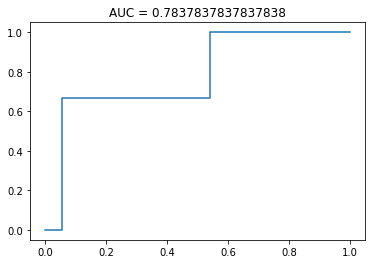

In [39]:
# We define the ytrue and yscore for the AUC
y_true = Y_test # acá va una lista con 0 o 1 según si falleció o no para cada linea de la test sample
y_scores = model.predict(X_test) # acá va una lista con el output de la NN para cada linea del test sample
# And compute it
# estas dos lineas que siguen son las lineas claves que hacen el barrido en el threshoold de 0 a 1 y se van fijando cuantos acierta y cuantos no
auc = roc_auc_score(y_true, y_scores) 
fpr , tpr, _= roc_curve(y_true, y_scores)
plt.plot(fpr,tpr)
plt.title('AUC = '+str(auc))
plt.show()